# Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams

In [2]:
users_df = pd.read_csv(r'./Scraping/data/uber_users.csv') # Per user data
uber_df = pd.read_pickle(r'./data/uber_tk.p')
uber_df_copy = uber_df.copy()
# Delete index column
users_df.drop(users_df.columns[0], axis=1, inplace=True)
users_df_copy = users_df.copy()

In [3]:
covid_date = np.datetime64('2020-04-01T01:00:00.000000+0100')

C:\Users\18199\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


In [4]:
users_df.head()

user  listed  followers
0  Michael05914091       0          8
1        ShieldVoC      18      17566
2          fltrtae      15       1717
3    Lucky00890359       0          0
4  zhenyalindgardt       1         55

In [5]:
uber_df.head()

source           source_id         target   target_id  \
0  Uber_Support          2815754953  wordofbrandon  2566081240   
1  Uber_Support          2815754953  wordofbrandon  2566081240   
2  Uber_Support          2815754953      CapeVgirl   719534538   
3  Uber_Support          2815754953      CapeVgirl   719534538   
4  SatishInnov8  722043526461145088   Uber_Support  2815754953   

  type_of_content          created_at  \
0           Reply 2019-08-31 10:53:53   
1           Reply 2019-08-31 10:53:53   
2           Reply 2019-10-01 07:45:30   
3           Reply 2019-10-01 07:45:30   
4           Reply 2019-12-09 17:11:51   

                                            all_data  \
0  {'created_at': 'Sat Aug 31 10:53:53 +0000 2019...   
1  {'created_at': 'Sat Aug 31 10:53:53 +0000 2019...   
2  {'created_at': 'Tue Oct 01 07:45:30 +0000 2019...   
3  {'created_at': 'Tue Oct 01 07:45:30 +0000 2019...   
4  {'created_at': 'Mon Dec 09 17:11:51 +0000 2019...   

                                                text  
0  [wordofbrandon, thanks, bringing, attention, w...  
1  [wordofbrandon, thanks, bringing, attention, w...  
2  [capevgirl, help, suggest, restarting, app, wo...  
3  [capevgirl, help, suggest, restarting, app, wo...  
4  [ubersupport, wish, respectfully, state, regul...

In [6]:
uber_df['all_data'][0]

{'created_at': 'Sat Aug 31 10:53:53 +0000 2019',
 'id': 1167752362733293568,
 'id_str': '1167752362733293568',
 'text': '@wordofbrandon Thanks for bringing this to our attention, @wordofbrandon. Our team is currently reviewing and will… https://t.co/9laWax1Uoh',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'wordofbrandon',
    'name': 'Brandon Jones',
    'id': 2566081240,
    'id_str': '2566081240',
    'indices': [0, 14]},
   {'screen_name': 'wordofbrandon',
    'name': 'Brandon Jones',
    'id': 2566081240,
    'id_str': '2566081240',
    'indices': [58, 72]}],
  'urls': [{'url': 'https://t.co/9laWax1Uoh',
    'expanded_url': 'https://twitter.com/i/web/status/1167752362733293568',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [116, 139]}]},
 'source': '<a href="https://www.sprinklr.com" rel="nofollow">Sprinklr</a>',
 'in_reply_to_status_id': 1167748661633142784,
 'in_reply_to_status_id_str': '11677486616331

# All Network

In [7]:
uber_df['type_of_content'].value_counts()

Reply      5253
Mention     254
Tweet        61
Name: type_of_content, dtype: int64

In [8]:
# Calculate types per user
users_df['reply_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('source')['type_of_content'].transform('count'))
users_df['reply_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('target')['type_of_content'].transform('count'))
users_df['mention_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('source')['type_of_content'].transform('count'))
users_df['mention_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('target')['type_of_content'].transform('count'))
users_df['tweet_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('source')['type_of_content'].transform('count'))
users_df['tweet_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('target')['type_of_content'].transform('count'))

In [9]:
users_df.describe()

listed     followers   reply_sent  reply_recieved  mention_sent  \
count    2578.000000  2.578000e+03  2502.000000     2502.000000     63.000000   
mean      133.553142  5.738144e+04   262.248601     1992.258993      4.714286   
std      3042.780387  1.213325e+06   480.116203     1489.011667      4.598136   
min         0.000000  0.000000e+00     1.000000        1.000000      1.000000   
25%         0.000000  3.000000e+00     1.000000        5.250000      1.000000   
50%         0.000000  3.500000e+01     2.000000     3126.000000      3.000000   
75%         3.000000  2.492500e+02     9.000000     3126.000000      8.000000   
max    147751.000000  5.338561e+07  1149.000000     3126.000000     13.000000   

       mention_recieved  tweet_sent  tweet_recieved  
count         63.000000   13.000000       13.000000  
mean          72.190476    2.000000        2.000000  
std           42.185786    1.414214        1.414214  
min            1.000000    1.000000        1.000000  
25%           22.000000    1.000000        1.000000  
50%           65.000000    1.000000        1.000000  
75%          115.000000    4.000000        4.000000  
max          115.000000    4.000000        4.000000

In [10]:
users_df.fillna(0, inplace=True) # Consitency
users_df

user  listed  followers  reply_sent  reply_recieved  \
0     Michael05914091       0          8      1149.0             3.0   
1           ShieldVoC      18      17566      1149.0             3.0   
2             fltrtae      15       1717      1149.0             4.0   
3       Lucky00890359       0          0      1149.0             4.0   
4     zhenyalindgardt       1         55         3.0          3126.0   
...               ...     ...        ...         ...             ...   
2573    fayedicksonxo       0        213         1.0          3126.0   
2574     Iam_bahuguna       0         90         1.0          3126.0   
2575         ajb_neuk       0          3         0.0             0.0   
2576           k_sovs       0          2         0.0             0.0   
2577        MY0U1SANA      22       3946         1.0          3126.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           8.0             115.0         0.0             0.0  
2576           8.0               2.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 9 columns]

In [11]:
# Create network
G = nx.DiGraph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

In [12]:
rcParams['figure.figsize'] = 30, 20
pos = nx.spring_layout(G, scale=0.15, k=0.5/np.sqrt(G.order()))
nx.draw(G, pos, node_color='lightgreen')

In [13]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

index         0
0      Uber_Support  1.215641
1     wordofbrandon  0.000774
2         CapeVgirl  0.000774
3      SatishInnov8  0.000774
4        realchetty  0.000774
...             ...       ...
2579        Nezz911  0.001161
2580    NeoVonAxiom  0.000387
2581       ajb_neuk  0.000774
2582   Iam_bahuguna  0.000387
2583      MY0U1SANA  0.000774

[2584 rows x 2 columns]

In [14]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

index         0
0      Uber_Support  0.897051
1     wordofbrandon  0.450255
2         CapeVgirl  0.450255
3      SatishInnov8  0.000000
4        realchetty  0.449965
...             ...       ...
2579        Nezz911  0.449965
2580    NeoVonAxiom  0.000000
2581       ajb_neuk  0.449965
2582   Iam_bahuguna  0.000000
2583      MY0U1SANA  0.000000

[2584 rows x 2 columns]

In [15]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

index         0
0      Uber_Support  0.304169
1     wordofbrandon  0.000000
2         CapeVgirl  0.000000
3      SatishInnov8  0.000000
4        realchetty  0.000000
...             ...       ...
2579        Nezz911  0.000012
2580    NeoVonAxiom  0.000000
2581       ajb_neuk  0.000000
2582   Iam_bahuguna  0.000000
2583      MY0U1SANA  0.000000

[2584 rows x 2 columns]

In [16]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index')
network_measures

index       0_x       0_y         0
0      Uber_Support  1.215641  0.897051  0.304169
1     wordofbrandon  0.000774  0.450255  0.000000
2         CapeVgirl  0.000774  0.450255  0.000000
3      SatishInnov8  0.000774  0.000000  0.000000
4        realchetty  0.000774  0.449965  0.000000
...             ...       ...       ...       ...
2579        Nezz911  0.001161  0.449965  0.000012
2580    NeoVonAxiom  0.000387  0.000000  0.000000
2581       ajb_neuk  0.000774  0.449965  0.000000
2582   Iam_bahuguna  0.000387  0.000000  0.000000
2583      MY0U1SANA  0.000774  0.000000  0.000000

[2584 rows x 4 columns]

In [17]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness'] # Consistent formatting

In [18]:
network_measures = network_measures.merge(users_df, on='user') # Merge on unique user name
network_measures

user    degree  closeness  betweenness  listed  followers  \
0      Uber_Support  1.215641   0.897051     0.304169     523     591423   
1     wordofbrandon  0.000774   0.450255     0.000000      56      24501   
2         CapeVgirl  0.000774   0.450255     0.000000       9        133   
3      SatishInnov8  0.000774   0.000000     0.000000       1        441   
4        realchetty  0.000774   0.449965     0.000000       1        138   
...             ...       ...        ...          ...     ...        ...   
2573        Nezz911  0.001161   0.449965     0.000012       4        658   
2574    NeoVonAxiom  0.000387   0.000000     0.000000       0          4   
2575       ajb_neuk  0.000774   0.449965     0.000000       0          3   
2576   Iam_bahuguna  0.000387   0.000000     0.000000       0         90   
2577      MY0U1SANA  0.000774   0.000000     0.000000      22       3946   

      reply_sent  reply_recieved  mention_sent  mention_recieved  tweet_sent  \
0            1.0          3126.0           0.0               0.0         0.0   
1            1.0          3126.0           0.0               0.0         0.0   
2            1.0          3126.0           0.0               0.0         0.0   
3            1.0          3126.0           0.0               0.0         0.0   
4         1149.0             1.0           0.0               0.0         0.0   
...          ...             ...           ...               ...         ...   
2573         2.0           119.0           0.0               0.0         0.0   
2574        13.0          3126.0           0.0               0.0         0.0   
2575         0.0             0.0           8.0             115.0         0.0   
2576         1.0          3126.0           0.0               0.0         0.0   
2577         1.0          3126.0           0.0               0.0         0.0   

      tweet_recieved  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
2573             0.0  
2574             0.0  
2575             0.0  
2576             0.0  
2577             0.0  

[2578 rows x 12 columns]

In [19]:
network_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2578 entries, 0 to 2577
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user              2578 non-null   object 
 1   degree            2578 non-null   float64
 2   closeness         2578 non-null   float64
 3   betweenness       2578 non-null   float64
 4   listed            2578 non-null   int64  
 5   followers         2578 non-null   int64  
 6   reply_sent        2578 non-null   float64
 7   reply_recieved    2578 non-null   float64
 8   mention_sent      2578 non-null   float64
 9   mention_recieved  2578 non-null   float64
 10  tweet_sent        2578 non-null   float64
 11  tweet_recieved    2578 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 261.8+ KB


In [20]:
network_measures.set_index('user', inplace=True)

In [21]:
# Normalize
scaled_features = MinMaxScaler().fit_transform(network_measures.values)

In [22]:
normalized_network_measures = pd.DataFrame(scaled_features, index=network_measures.index, columns=network_measures.columns)
normalized_network_measures

degree  closeness  betweenness    listed     followers  \
user                                                                      
Uber_Support   1.000000   1.000000     1.000000  0.003540  1.107832e-02   
wordofbrandon  0.000319   0.501927     0.000000  0.000379  4.589439e-04   
CapeVgirl      0.000319   0.501927     0.000000  0.000061  2.491308e-06   
SatishInnov8   0.000319   0.000000     0.000000  0.000007  8.260653e-06   
realchetty     0.000319   0.501604     0.000000  0.000007  2.584966e-06   
...                 ...        ...          ...       ...           ...   
Nezz911        0.000637   0.501604     0.000039  0.000027  1.232542e-05   
NeoVonAxiom    0.000000   0.000000     0.000000  0.000000  7.492656e-08   
ajb_neuk       0.000319   0.501604     0.000000  0.000000  5.619492e-08   
Iam_bahuguna   0.000000   0.000000     0.000000  0.000000  1.685848e-06   
MY0U1SANA      0.000319   0.000000     0.000000  0.000149  7.391505e-05   

               reply_sent  reply_recieved  mention_sent  mention_recieved  \
user                                                                        
Uber_Support     0.000870        1.000000      0.000000               0.0   
wordofbrandon    0.000870        1.000000      0.000000               0.0   
CapeVgirl        0.000870        1.000000      0.000000               0.0   
SatishInnov8     0.000870        1.000000      0.000000               0.0   
realchetty       1.000000        0.000320      0.000000               0.0   
...                   ...             ...           ...               ...   
Nezz911          0.001741        0.038068      0.000000               0.0   
NeoVonAxiom      0.011314        1.000000      0.000000               0.0   
ajb_neuk         0.000000        0.000000      0.615385               1.0   
Iam_bahuguna     0.000870        1.000000      0.000000               0.0   
MY0U1SANA        0.000870        1.000000      0.000000               0.0   

               tweet_sent  tweet_recieved  
user                                       
Uber_Support          0.0             0.0  
wordofbrandon         0.0             0.0  
CapeVgirl             0.0             0.0  
SatishInnov8          0.0             0.0  
realchetty            0.0             0.0  
...                   ...             ...  
Nezz911               0.0             0.0  
NeoVonAxiom           0.0             0.0  
ajb_neuk              0.0             0.0  
Iam_bahuguna          0.0             0.0  
MY0U1SANA             0.0             0.0  

[2578 rows x 11 columns]

In [23]:
normalized_network_measures['score'] = normalized_network_measures[:].sum(axis=1)
normalized_network_measures['score']

user
Uber_Support     4.015488
wordofbrandon    1.503954
CapeVgirl        1.503180
SatishInnov8     1.001204
realchetty       1.502252
                   ...   
Nezz911          0.542129
NeoVonAxiom      1.011314
ajb_neuk         2.117308
Iam_bahuguna     1.000872
MY0U1SANA        1.001412
Name: score, Length: 2578, dtype: float64

In [24]:
# Top 200
results = normalized_network_measures.nlargest(200, 'score', keep='all')
results

degree  closeness  betweenness    listed     followers  \
user                                                                      
Uber_Support   1.000000   1.000000          1.0  0.003540  1.107832e-02   
1975aregr8t    0.000319   0.501604          0.0  0.000000  6.930707e-07   
MrsKiraly      0.000319   0.501604          0.0  0.000000  1.311215e-07   
ajb_neuk       0.000319   0.501604          0.0  0.000000  5.619492e-08   
CNN            0.000000   0.000432          0.0  1.000000  1.000000e+00   
...                 ...        ...          ...       ...           ...   
ariojosdemiel  0.000319   0.501604          0.0  0.000000  1.142630e-06   
AcreUK         0.000319   0.501604          0.0  0.000129  4.126580e-05   
divyanshu_nd   0.000956   0.501927          0.0  0.000054  1.869418e-05   
NadiaZammal    0.000319   0.501604          0.0  0.000142  7.811094e-06   
Jordan13Coops  0.000319   0.501604          0.0  0.000068  7.576949e-05   

               reply_sent  reply_recieved  mention_sent  mention_recieved  \
user                                                                        
Uber_Support     0.000870        1.000000      0.000000               0.0   
1975aregr8t      0.000000        0.000000      0.000000               0.0   
MrsKiraly        0.000000        0.000000      0.000000               0.0   
ajb_neuk         0.000000        0.000000      0.615385               1.0   
CNN              0.002611        0.079655      0.000000               0.0   
...                   ...             ...           ...               ...   
ariojosdemiel    1.000000        0.001919      0.000000               0.0   
AcreUK           0.001741        1.000000      0.000000               0.0   
divyanshu_nd     0.000870        1.000000      0.000000               0.0   
NadiaZammal      0.001741        1.000000      0.000000               0.0   
Jordan13Coops    0.001741        1.000000      0.000000               0.0   

               tweet_sent  tweet_recieved     score  
user                                                 
Uber_Support          0.0             0.0  4.015488  
1975aregr8t           1.0             1.0  2.501924  
MrsKiraly             1.0             1.0  2.501923  
ajb_neuk              0.0             0.0  2.117308  
CNN                   0.0             0.0  2.082697  
...                   ...             ...       ...  
ariojosdemiel         0.0             0.0  1.503843  
AcreUK                0.0             0.0  1.503833  
divyanshu_nd          0.0             0.0  1.503826  
NadiaZammal           0.0             0.0  1.503813  
Jordan13Coops         0.0             0.0  1.503807  

[200 rows x 12 columns]

In [25]:
results.to_csv(r'.\data\all_aggregated_uber_results.csv')

# Pre-COVID

In [26]:
users_df = users_df_copy.copy() # Per user data
uber_df = uber_df_copy.copy()

In [27]:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   source           5568 non-null   object        
 1   source_id        5568 non-null   object        
 2   target           5568 non-null   object        
 3   target_id        5568 non-null   object        
 4   type_of_content  5568 non-null   object        
 5   created_at       5568 non-null   datetime64[ns]
 6   all_data         5568 non-null   object        
 7   text             5568 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 348.1+ KB


In [28]:
uber_df = uber_df[uber_df['created_at'] <= covid_date]

In [29]:
# Calculate types per user
users_df['reply_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('source')['type_of_content'].transform('count'))
users_df['reply_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('target')['type_of_content'].transform('count'))
users_df['mention_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('source')['type_of_content'].transform('count'))
users_df['mention_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('target')['type_of_content'].transform('count'))
users_df['tweet_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('source')['type_of_content'].transform('count'))
users_df['tweet_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('target')['type_of_content'].transform('count'))

In [30]:
users_df.fillna(0, inplace=True) # Consitency
users_df

user  listed  followers  reply_sent  reply_recieved  \
0     Michael05914091       0          8        98.0             2.0   
1           ShieldVoC      18      17566        98.0             2.0   
2             fltrtae      15       1717        98.0             2.0   
3       Lucky00890359       0          0        98.0             2.0   
4     zhenyalindgardt       1         55         3.0           480.0   
...               ...     ...        ...         ...             ...   
2573    fayedicksonxo       0        213         0.0             0.0   
2574     Iam_bahuguna       0         90         0.0             0.0   
2575         ajb_neuk       0          3         0.0             0.0   
2576           k_sovs       0          2         0.0             0.0   
2577        MY0U1SANA      22       3946         0.0             0.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           0.0               0.0         0.0             0.0  
2576           0.0               0.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 9 columns]

In [31]:
# Create network
G = nx.DiGraph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

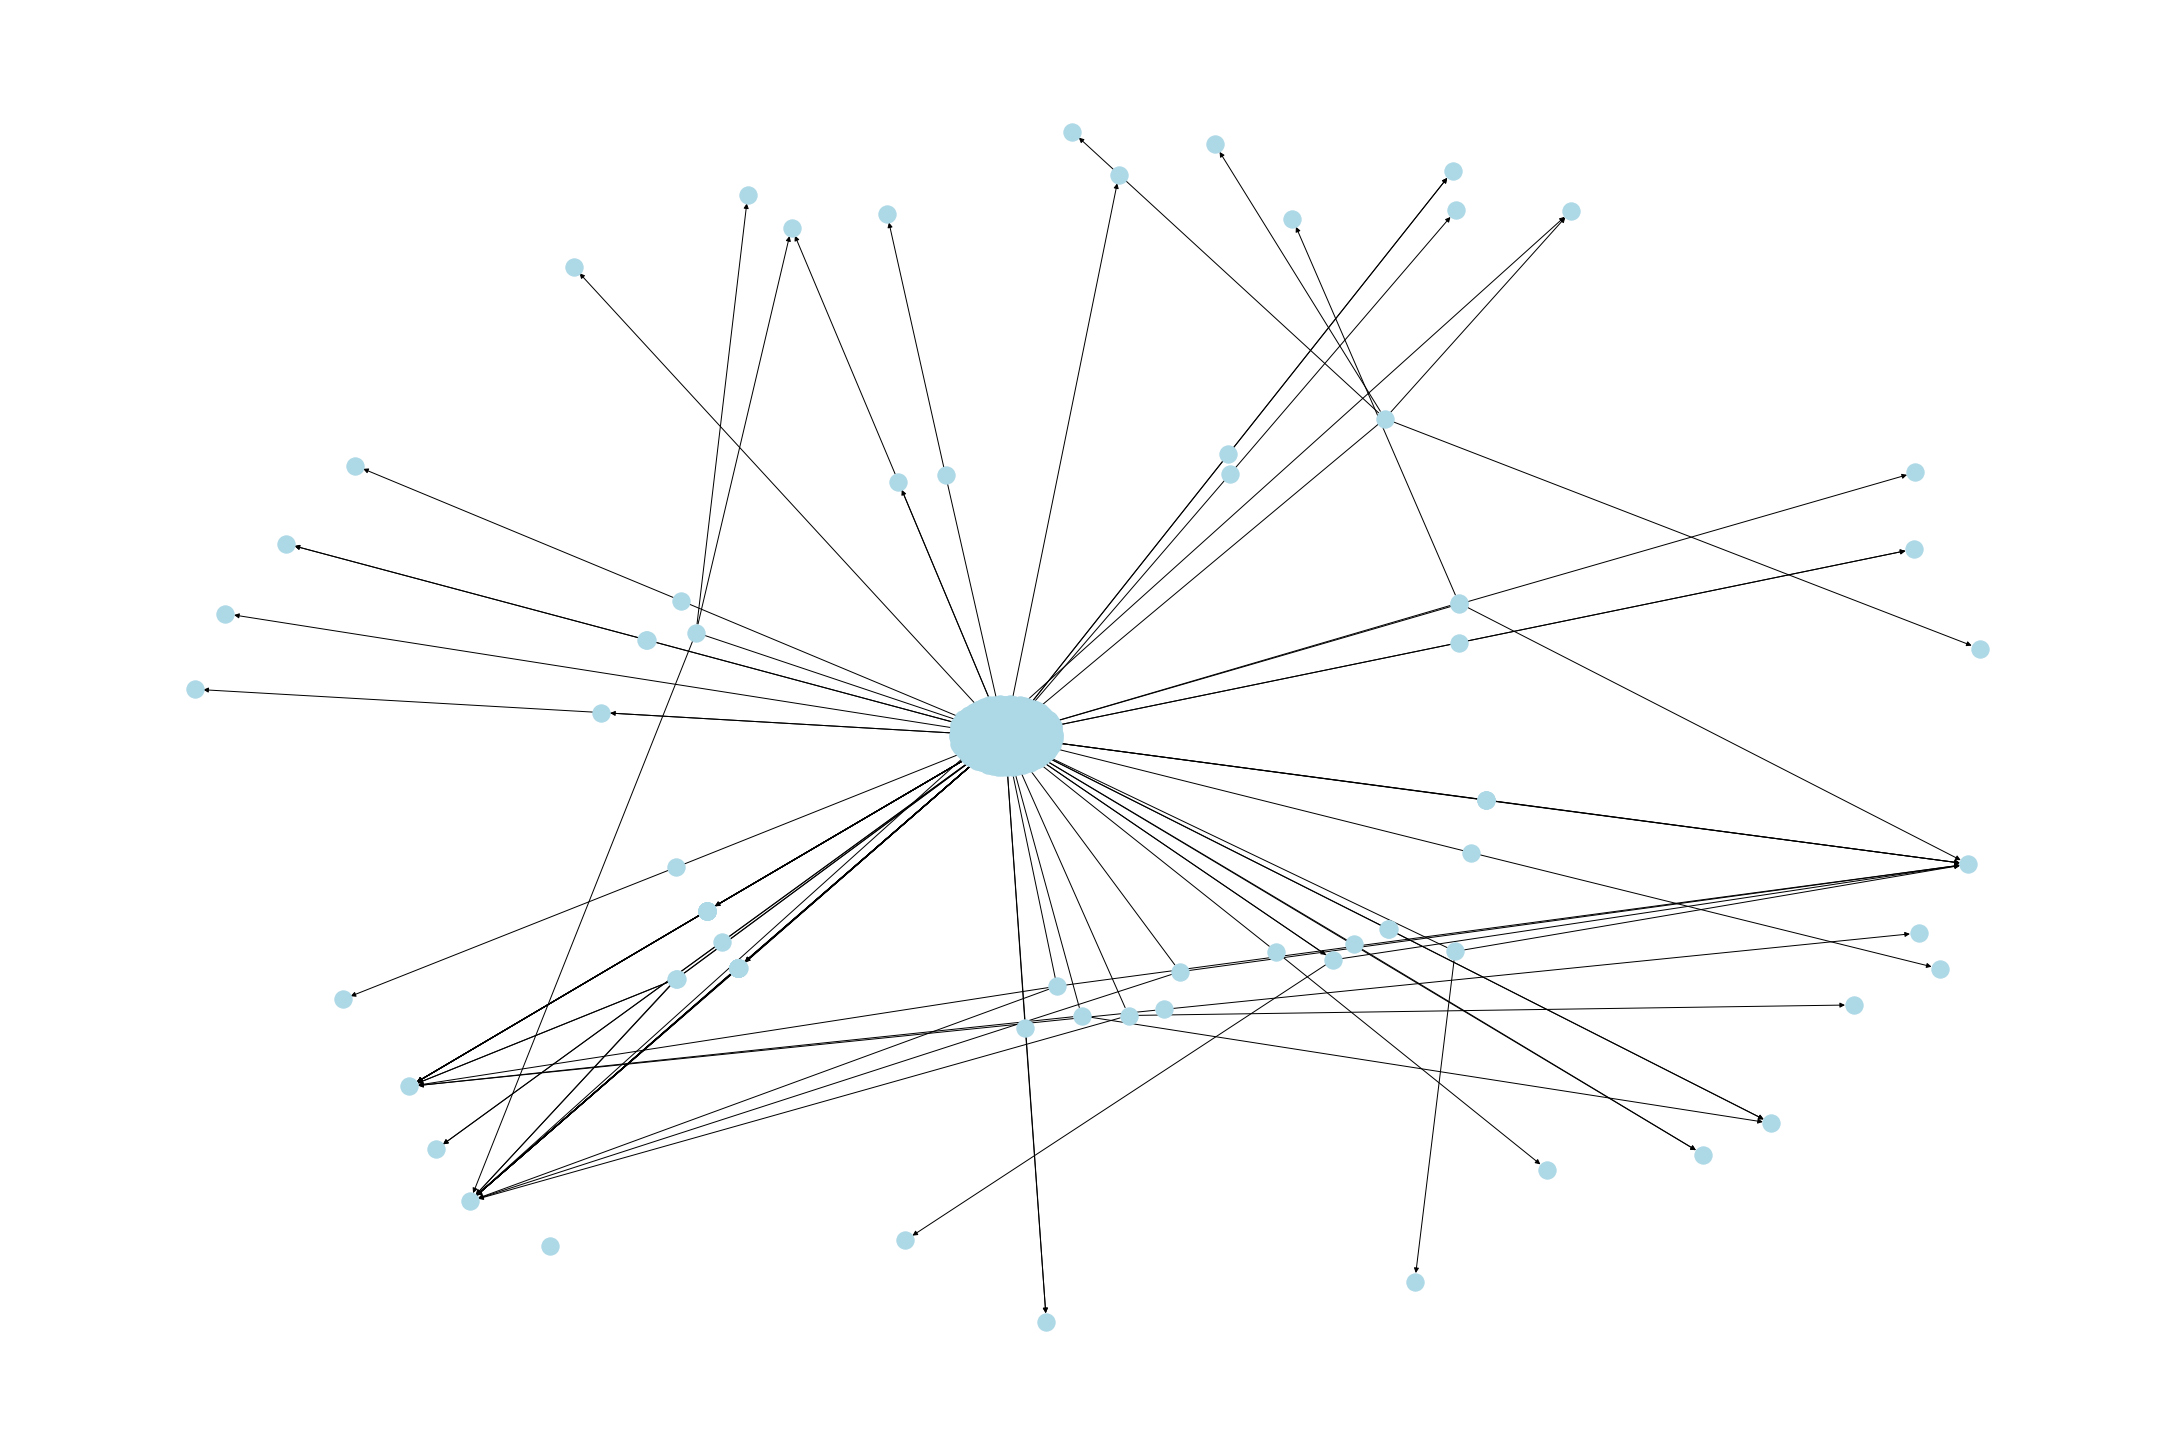

In [32]:
rcParams['figure.figsize'] = 30, 20
pos = nx.spring_layout(G, scale=0.15, k=0.5/np.sqrt(G.order()))
nx.draw(G, pos, node_color='lightblue')

In [33]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

index         0
0     Uber_Support  1.057940
1    wordofbrandon  0.002146
2        CapeVgirl  0.002146
3     SatishInnov8  0.004292
4       realchetty  0.004292
..             ...       ...
462   aIonelynight  0.002146
463       ImAndreM  0.002146
464   hegemonprime  0.002146
465      jstocks21  0.002146
466       matdel69  0.002146

[467 rows x 2 columns]

In [34]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

index         0
0     Uber_Support  0.927039
1    wordofbrandon  0.465129
2        CapeVgirl  0.465129
3     SatishInnov8  0.000000
4       realchetty  0.464056
..             ...       ...
462   aIonelynight  0.000000
463       ImAndreM  0.000000
464   hegemonprime  0.000000
465      jstocks21  0.000000
466       matdel69  0.465129

[467 rows x 2 columns]

In [35]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

index         0
0     Uber_Support  0.135055
1    wordofbrandon  0.000000
2        CapeVgirl  0.000000
3     SatishInnov8  0.000000
4       realchetty  0.000000
..             ...       ...
462   aIonelynight  0.000000
463       ImAndreM  0.000000
464   hegemonprime  0.000000
465      jstocks21  0.000000
466       matdel69  0.000000

[467 rows x 2 columns]

In [36]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index')
network_measures

index       0_x       0_y         0
0     Uber_Support  1.057940  0.927039  0.135055
1    wordofbrandon  0.002146  0.465129  0.000000
2        CapeVgirl  0.002146  0.465129  0.000000
3     SatishInnov8  0.004292  0.000000  0.000000
4       realchetty  0.004292  0.464056  0.000000
..             ...       ...       ...       ...
462   aIonelynight  0.002146  0.000000  0.000000
463       ImAndreM  0.002146  0.000000  0.000000
464   hegemonprime  0.002146  0.000000  0.000000
465      jstocks21  0.002146  0.000000  0.000000
466       matdel69  0.002146  0.465129  0.000000

[467 rows x 4 columns]

In [37]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness'] # Consistent formatting

In [38]:
network_measures = network_measures.merge(users_df, on='user') # Merge on unique user name
network_measures

user    degree  closeness  betweenness  listed  followers  \
0     Uber_Support  1.057940   0.927039     0.135055     523     591423   
1    wordofbrandon  0.002146   0.465129     0.000000      56      24501   
2        CapeVgirl  0.002146   0.465129     0.000000       9        133   
3     SatishInnov8  0.004292   0.000000     0.000000       1        441   
4       realchetty  0.004292   0.464056     0.000000       1        138   
..             ...       ...        ...          ...     ...        ...   
462   aIonelynight  0.002146   0.000000     0.000000      56       5007   
463       ImAndreM  0.002146   0.000000     0.000000       6        273   
464   hegemonprime  0.002146   0.000000     0.000000      33        295   
465      jstocks21  0.002146   0.000000     0.000000       7        342   
466       matdel69  0.002146   0.465129     0.000000       0          1   

     reply_sent  reply_recieved  mention_sent  mention_recieved  tweet_sent  \
0           1.0           480.0           0.0               0.0         0.0   
1           1.0           480.0           0.0               0.0         0.0   
2           1.0           480.0           0.0               0.0         0.0   
3           1.0           480.0           0.0               0.0         0.0   
4          98.0             1.0           0.0               0.0         0.0   
..          ...             ...           ...               ...         ...   
462         1.0           480.0           0.0               0.0         0.0   
463         1.0           480.0           0.0               0.0         0.0   
464         1.0           480.0           0.0               0.0         0.0   
465        98.0             2.0           0.0               0.0         0.0   
466         0.0             0.0           0.0               0.0         0.0   

     tweet_recieved  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
..              ...  
462             0.0  
463             0.0  
464             0.0  
465             0.0  
466             0.0  

[467 rows x 12 columns]

In [39]:
network_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467 entries, 0 to 466
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user              467 non-null    object 
 1   degree            467 non-null    float64
 2   closeness         467 non-null    float64
 3   betweenness       467 non-null    float64
 4   listed            467 non-null    int64  
 5   followers         467 non-null    int64  
 6   reply_sent        467 non-null    float64
 7   reply_recieved    467 non-null    float64
 8   mention_sent      467 non-null    float64
 9   mention_recieved  467 non-null    float64
 10  tweet_sent        467 non-null    float64
 11  tweet_recieved    467 non-null    float64
dtypes: float64(9), int64(2), object(1)
memory usage: 47.4+ KB


In [40]:
network_measures.set_index('user', inplace=True)

In [41]:
# Normalize
scaled_features = MinMaxScaler().fit_transform(network_measures.values)

In [42]:
normalized_network_measures = pd.DataFrame(scaled_features, index=network_measures.index, columns=network_measures.columns)
normalized_network_measures

degree  closeness  betweenness    listed     followers  \
user                                                                      
Uber_Support   1.000000   1.000000          1.0  0.003540  1.107832e-02   
wordofbrandon  0.000000   0.501737          0.0  0.000379  4.589439e-04   
CapeVgirl      0.000000   0.501737          0.0  0.000061  2.491308e-06   
SatishInnov8   0.002033   0.000000          0.0  0.000007  8.260653e-06   
realchetty     0.002033   0.500579          0.0  0.000007  2.584966e-06   
...                 ...        ...          ...       ...           ...   
aIonelynight   0.000000   0.000000          0.0  0.000379  9.378932e-05   
ImAndreM       0.000000   0.000000          0.0  0.000041  5.113738e-06   
hegemonprime   0.000000   0.000000          0.0  0.000223  5.525834e-06   
jstocks21      0.000000   0.000000          0.0  0.000047  6.406221e-06   
matdel69       0.000000   0.501737          0.0  0.000000  1.873164e-08   

               reply_sent  reply_recieved  mention_sent  mention_recieved  \
user                                                                        
Uber_Support     0.010204        1.000000           0.0               0.0   
wordofbrandon    0.010204        1.000000           0.0               0.0   
CapeVgirl        0.010204        1.000000           0.0               0.0   
SatishInnov8     0.010204        1.000000           0.0               0.0   
realchetty       1.000000        0.002083           0.0               0.0   
...                   ...             ...           ...               ...   
aIonelynight     0.010204        1.000000           0.0               0.0   
ImAndreM         0.010204        1.000000           0.0               0.0   
hegemonprime     0.010204        1.000000           0.0               0.0   
jstocks21        1.000000        0.004167           0.0               0.0   
matdel69         0.000000        0.000000           0.0               0.0   

               tweet_sent  tweet_recieved  
user                                       
Uber_Support          0.0             0.0  
wordofbrandon         0.0             0.0  
CapeVgirl             0.0             0.0  
SatishInnov8          0.0             0.0  
realchetty            0.0             0.0  
...                   ...             ...  
aIonelynight          0.0             0.0  
ImAndreM              0.0             0.0  
hegemonprime          0.0             0.0  
jstocks21             0.0             0.0  
matdel69              0.0             0.0  

[467 rows x 11 columns]

In [43]:
normalized_network_measures['score'] = normalized_network_measures[:].sum(axis=1)
normalized_network_measures['score']

user
Uber_Support     4.024822
wordofbrandon    1.512779
CapeVgirl        1.512004
SatishInnov8     1.012252
realchetty       1.504705
                   ...   
aIonelynight     1.010677
ImAndreM         1.010250
hegemonprime     1.010433
jstocks21        1.004220
matdel69         0.501737
Name: score, Length: 467, dtype: float64

In [44]:
# Top 200
results = normalized_network_measures.nlargest(200, 'score', keep='all')
results

degree  closeness  betweenness    listed     followers  \
user                                                                       
Uber_Support    1.000000   1.000000     1.000000  0.003540  1.107832e-02   
CNN             0.000000   0.002315     0.000000  1.000000  1.000000e+00   
SocialistBooks  0.000000   0.000000     0.000000  0.000393  1.762647e-05   
gregory_finney  0.006098   0.500579     0.029284  0.000277  2.165378e-05   
JeremyCushman   0.002033   0.500579     0.000000  0.000264  1.343059e-05   
...                  ...        ...          ...       ...           ...   
AdrianaStills   0.002033   0.000000     0.000000  0.000000  9.365820e-08   
imprincejerry   0.002033   0.000000     0.000000  0.000000  0.000000e+00   
Jtwites1        0.002033   0.000000     0.000000  0.000000  0.000000e+00   
palstakeaway    0.000000   0.000000     0.000000  0.001394  3.236827e-05   
k13chris        0.000000   0.000000     0.000000  0.001225  4.991982e-05   

                reply_sent  reply_recieved  mention_sent  mention_recieved  \
user                                                                         
Uber_Support      0.010204        1.000000           0.0               0.0   
CNN               0.030612        0.054167           0.0               0.0   
SocialistBooks    0.000000        0.000000           0.0               0.0   
gregory_finney    0.010204        1.000000           0.0               0.0   
JeremyCushman     0.030612        1.000000           0.0               0.0   
...                    ...             ...           ...               ...   
AdrianaStills     0.010204        1.000000           0.0               0.0   
imprincejerry     0.010204        1.000000           0.0               0.0   
Jtwites1          0.010204        1.000000           0.0               0.0   
palstakeaway      0.010204        1.000000           0.0               0.0   
k13chris          0.010204        1.000000           0.0               0.0   

                tweet_sent  tweet_recieved     score  
user                                                  
Uber_Support           0.0             0.0  4.024822  
CNN                    0.0             0.0  2.087094  
SocialistBooks         1.0             1.0  2.000410  
gregory_finney         0.0             0.0  1.546464  
JeremyCushman          0.0             0.0  1.533502  
...                    ...             ...       ...  
AdrianaStills          0.0             0.0  1.012237  
imprincejerry          0.0             0.0  1.012237  
Jtwites1               0.0             0.0  1.012237  
palstakeaway           0.0             0.0  1.011631  
k13chris               0.0             0.0  1.011479  

[200 rows x 12 columns]

In [45]:
results.to_csv(r'.\data\precov_aggregated_uber_results.csv')

# Post-COVID

In [46]:
users_df = users_df_copy.copy() # Per user data
uber_df = uber_df_copy.copy()

In [47]:
uber_df = uber_df[uber_df['created_at'] > covid_date]

In [48]:
# Calculate types per user
users_df['reply_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('source')['type_of_content'].transform('count'))
users_df['reply_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('target')['type_of_content'].transform('count'))
users_df['mention_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('source')['type_of_content'].transform('count'))
users_df['mention_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('target')['type_of_content'].transform('count'))
users_df['tweet_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('source')['type_of_content'].transform('count'))
users_df['tweet_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('target')['type_of_content'].transform('count'))

In [49]:
users_df.fillna(0, inplace=True) # Consitency
users_df

user  listed  followers  reply_sent  reply_recieved  \
0     Michael05914091       0          8         0.0             0.0   
1           ShieldVoC      18      17566         0.0             0.0   
2             fltrtae      15       1717         0.0             0.0   
3       Lucky00890359       0          0         0.0             0.0   
4     zhenyalindgardt       1         55         0.0             0.0   
...               ...     ...        ...         ...             ...   
2573    fayedicksonxo       0        213         1.0          2646.0   
2574     Iam_bahuguna       0         90         1.0          2646.0   
2575         ajb_neuk       0          3         0.0             0.0   
2576           k_sovs       0          2         0.0             0.0   
2577        MY0U1SANA      22       3946         1.0          2646.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           8.0             115.0         0.0             0.0  
2576           8.0               2.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 9 columns]

In [50]:
# Create network
G = nx.DiGraph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

In [51]:
rcParams['figure.figsize'] = 30, 20
pos = nx.spring_layout(G, scale=0.15, k=0.5/np.sqrt(G.order()))
nx.draw(G, pos, node_color='red')

In [52]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

index         0
0        Uber_Support  1.241331
1             fltrtae  0.012652
2     Michael05914091  0.000937
3          maybeharsh  0.000937
4          Lbabyrouth  0.001406
...               ...       ...
2130          Nezz911  0.001406
2131      NeoVonAxiom  0.000469
2132         ajb_neuk  0.000937
2133     Iam_bahuguna  0.000469
2134        MY0U1SANA  0.000937

[2135 rows x 2 columns]

In [53]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

index         0
0        Uber_Support  0.883834
1             fltrtae  0.446936
2     Michael05914091  0.444006
3          maybeharsh  0.443656
4          Lbabyrouth  0.444123
...               ...       ...
2130          Nezz911  0.443656
2131      NeoVonAxiom  0.000000
2132         ajb_neuk  0.443656
2133     Iam_bahuguna  0.000000
2134        MY0U1SANA  0.000000

[2135 rows x 2 columns]

In [54]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

index         0
0        Uber_Support  0.337344
1             fltrtae  0.000000
2     Michael05914091  0.000000
3          maybeharsh  0.000000
4          Lbabyrouth  0.000000
...               ...       ...
2130          Nezz911  0.000015
2131      NeoVonAxiom  0.000000
2132         ajb_neuk  0.000000
2133     Iam_bahuguna  0.000000
2134        MY0U1SANA  0.000000

[2135 rows x 2 columns]

In [55]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index')
network_measures

index       0_x       0_y         0
0        Uber_Support  1.241331  0.883834  0.337344
1             fltrtae  0.012652  0.446936  0.000000
2     Michael05914091  0.000937  0.444006  0.000000
3          maybeharsh  0.000937  0.443656  0.000000
4          Lbabyrouth  0.001406  0.444123  0.000000
...               ...       ...       ...       ...
2130          Nezz911  0.001406  0.443656  0.000015
2131      NeoVonAxiom  0.000469  0.000000  0.000000
2132         ajb_neuk  0.000937  0.443656  0.000000
2133     Iam_bahuguna  0.000469  0.000000  0.000000
2134        MY0U1SANA  0.000937  0.000000  0.000000

[2135 rows x 4 columns]

In [56]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness'] # Consistent formatting

In [57]:
network_measures = network_measures.merge(users_df, on='user') # Merge on unique user name
network_measures

user    degree  closeness  betweenness  listed  followers  \
0        Uber_Support  1.241331   0.883834     0.337344     523     591423   
1             fltrtae  0.012652   0.446936     0.000000      15       1717   
2     Michael05914091  0.000937   0.444006     0.000000       0          8   
3          maybeharsh  0.000937   0.443656     0.000000       0          0   
4          Lbabyrouth  0.001406   0.444123     0.000000       0         23   
...               ...       ...        ...          ...     ...        ...   
2124          Nezz911  0.001406   0.443656     0.000015       4        658   
2125      NeoVonAxiom  0.000469   0.000000     0.000000       0          4   
2126         ajb_neuk  0.000937   0.443656     0.000000       0          3   
2127     Iam_bahuguna  0.000469   0.000000     0.000000       0         90   
2128        MY0U1SANA  0.000937   0.000000     0.000000      22       3946   

      reply_sent  reply_recieved  mention_sent  mention_recieved  tweet_sent  \
0            0.0             0.0           0.0               0.0         0.0   
1            0.0             0.0           0.0               0.0         0.0   
2            0.0             0.0           0.0               0.0         0.0   
3            1.0          2646.0           0.0               0.0         0.0   
4            0.0             0.0           0.0               0.0         0.0   
...          ...             ...           ...               ...         ...   
2124         2.0           111.0           0.0               0.0         0.0   
2125        13.0          2646.0           0.0               0.0         0.0   
2126         0.0             0.0           8.0             115.0         0.0   
2127         1.0          2646.0           0.0               0.0         0.0   
2128         1.0          2646.0           0.0               0.0         0.0   

      tweet_recieved  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
2124             0.0  
2125             0.0  
2126             0.0  
2127             0.0  
2128             0.0  

[2129 rows x 12 columns]

In [58]:
network_measures.set_index('user', inplace=True)

In [59]:
# Normalize
scaled_features = MinMaxScaler().fit_transform(network_measures.values)

In [60]:
normalized_network_measures = pd.DataFrame(scaled_features, index=network_measures.index, columns=network_measures.columns)
normalized_network_measures

degree  closeness  betweenness    listed     followers  \
user                                                                        
Uber_Support     1.000000   1.000000     1.000000  0.020191  2.723194e-02   
fltrtae          0.009819   0.505678     0.000000  0.000579  7.905887e-05   
Michael05914091  0.000378   0.502364     0.000000  0.000000  3.683582e-07   
maybeharsh       0.000378   0.501967     0.000000  0.000000  0.000000e+00   
Lbabyrouth       0.000755   0.502495     0.000000  0.000000  1.059030e-06   
...                   ...        ...          ...       ...           ...   
Nezz911          0.000755   0.501967     0.000044  0.000154  3.029746e-05   
NeoVonAxiom      0.000000   0.000000     0.000000  0.000000  1.841791e-07   
ajb_neuk         0.000378   0.501967     0.000000  0.000000  1.381343e-07   
Iam_bahuguna     0.000000   0.000000     0.000000  0.000000  4.144029e-06   
MY0U1SANA        0.000378   0.000000     0.000000  0.000849  1.816927e-04   

                 reply_sent  reply_recieved  mention_sent  mention_recieved  \
user                                                                          
Uber_Support       0.000000         0.00000      0.000000               0.0   
fltrtae            0.000000         0.00000      0.000000               0.0   
Michael05914091    0.000000         0.00000      0.000000               0.0   
maybeharsh         0.000951         1.00000      0.000000               0.0   
Lbabyrouth         0.000000         0.00000      0.000000               0.0   
...                     ...             ...           ...               ...   
Nezz911            0.001903         0.04195      0.000000               0.0   
NeoVonAxiom        0.012369         1.00000      0.000000               0.0   
ajb_neuk           0.000000         0.00000      0.615385               1.0   
Iam_bahuguna       0.000951         1.00000      0.000000               0.0   
MY0U1SANA          0.000951         1.00000      0.000000               0.0   

                 tweet_sent  tweet_recieved  
user                                         
Uber_Support            0.0             0.0  
fltrtae                 0.0             0.0  
Michael05914091         0.0             0.0  
maybeharsh              0.0             0.0  
Lbabyrouth              0.0             0.0  
...                     ...             ...  
Nezz911                 0.0             0.0  
NeoVonAxiom             0.0             0.0  
ajb_neuk                0.0             0.0  
Iam_bahuguna            0.0             0.0  
MY0U1SANA               0.0             0.0  

[2129 rows x 11 columns]

In [61]:
normalized_network_measures['score'] = normalized_network_measures[:].sum(axis=1)
normalized_network_measures['score']

user
Uber_Support       3.047423
fltrtae            0.516155
Michael05914091    0.502742
maybeharsh         1.503296
Lbabyrouth         0.503252
                     ...   
Nezz911            0.546804
NeoVonAxiom        1.012369
ajb_neuk           2.117729
Iam_bahuguna       1.000956
MY0U1SANA          1.002360
Name: score, Length: 2129, dtype: float64

In [62]:
# Top 200
results = normalized_network_measures.nlargest(200, 'score', keep='all')
results

degree  closeness  betweenness    listed     followers  \
user                                                                      
Uber_Support   1.000000   1.000000          1.0  0.020191  2.723194e-02   
1975aregr8t    0.000378   0.501967          0.0  0.000000  1.703657e-06   
MrsKiraly      0.000378   0.501967          0.0  0.000000  3.223134e-07   
ajb_neuk       0.000378   0.501967          0.0  0.000000  1.381343e-07   
Alex51354835   0.000378   0.501967          0.0  0.000000  4.604477e-08   
...                 ...        ...          ...       ...           ...   
chis1__        0.000378   0.501967          0.0  0.000039  3.784880e-05   
Raxwell_K      0.000378   0.501967          0.0  0.000000  6.837648e-05   
Starbucks      0.000378   0.001060          0.0  1.000000  5.028701e-01   
rumandritalin  0.000378   0.501967          0.0  0.000039  1.482642e-05   
mns3100813     0.000378   0.501967          0.0  0.000039  1.036007e-05   

               reply_sent  reply_recieved  mention_sent  mention_recieved  \
user                                                                        
Uber_Support     0.000000             0.0      0.000000          0.000000   
1975aregr8t      0.000000             0.0      0.000000          0.000000   
MrsKiraly        0.000000             0.0      0.000000          0.000000   
ajb_neuk         0.000000             0.0      0.615385          1.000000   
Alex51354835     0.000000             0.0      1.000000          0.565217   
...                   ...             ...           ...               ...   
chis1__          0.001903             1.0      0.000000          0.000000   
Raxwell_K        0.001903             1.0      0.000000          0.000000   
Starbucks        0.000000             0.0      0.000000          0.000000   
rumandritalin    0.001903             1.0      0.000000          0.000000   
mns3100813       0.001903             1.0      0.000000          0.000000   

               tweet_sent  tweet_recieved     score  
user                                                 
Uber_Support          0.0             0.0  3.047423  
1975aregr8t           1.0             1.0  2.502346  
MrsKiraly             1.0             1.0  2.502345  
ajb_neuk              0.0             0.0  2.117729  
Alex51354835          0.0             0.0  2.067562  
...                   ...             ...       ...  
chis1__               0.0             0.0  1.504324  
Raxwell_K             0.0             0.0  1.504316  
Starbucks             0.0             0.0  1.504308  
rumandritalin         0.0             0.0  1.504301  
mns3100813            0.0             0.0  1.504297  

[200 rows x 12 columns]

In [63]:
results.to_csv(r'.\data\postcov_aggregated_uber_results.csv')